### Урок 6. Градиентный бустинг.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
# Набор данных диабета (регрессия)
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [6]:
X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$.   
Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

#### __1__. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [34]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [65]:
# Максимальная глубина деревьев
max_depth = 5
# Шаг
eta = 0.1

In [80]:
n_trees_array = [1, 3, 5, 10, 20, 30, 50]

train_err = []
test_err  = []

for n_trees in n_trees_array:
    coefs = [1] * n_trees

    trees, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_err.append(mean_squared_error(y_test, test_prediction))

In [90]:
def trees_error_plt(n_trees_array, train_err, test_err):
    plt.figure(figsize = (12, 7))
    plt.xlabel('Trees')
    plt.ylabel('MSE')
    plt.yticks(np.arange(0, 25000, 2000))
    plt.xlim(0, n_trees_array[-1])
    plt.plot(n_trees_array, train_err, label='Train error')
    plt.plot(n_trees_array, test_err, label='Test error')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

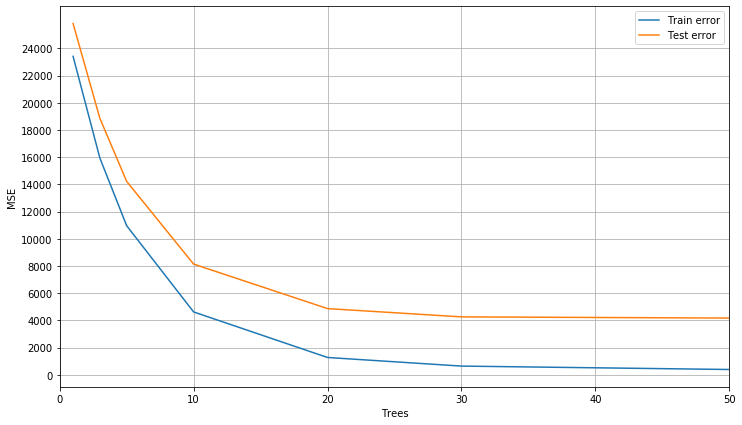

In [91]:
trees_error_plt(n_trees_array, train_trees_err, test_trees_err)

In [92]:
n_trees_array = 30
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth_arr = [1, 2, 3, 4, 5, 7, 8]

train_err = []
test_err  = []

for max_depth in max_depth_arr:

    trees, train_error, test_error = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err.append(mean_squared_error(y_train, train_prediction))

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err.append(mean_squared_error(y_test, test_prediction))

In [103]:
def depth_error_plt(max_arr, train_err, test_err):
    plt.figure(figsize = (12, 7))
    plt.xlabel('Trees')
    plt.ylabel('MSE')
    plt.xlim(1, max_arr[-1])
    plt.plot(max_arr, train_err, label='Train error')
    plt.plot(max_arr, test_err, label='Test error')
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()

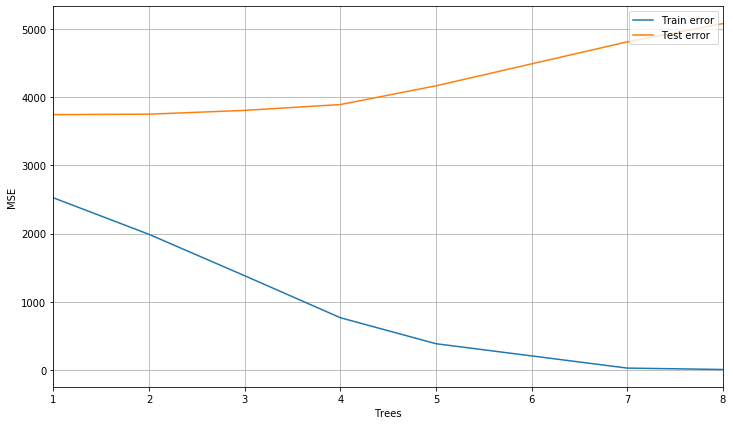

In [104]:
depth_error_plt(max_depth_arr, train_err, test_err)

__ВЫВОД:__   
При увеличении количества деревьев MSE модели градиентного бустинга уменьшается.   
При увеличении максимальной глубины деревьев - на train выборке MSE уменьшается, а на test выборке после глубины 2 начинает расти, что говорит о переобучении модели.

#### __2__.  Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [113]:
L = X_train.shape[0]
L2 = L//2
print(L)
print(L2)

331
165


In [114]:
def gb_st_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    L = X_train.shape[0]
    L2 = L//2  # Размер подвыборки
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        sample_indexes = np.random.randint(0, L, L2)
        X_tr_sample = X_train[sample_indexes]
        y_tr_sample = y_train[sample_indexes]
        
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_tr_sample, y_tr_sample)
            
            train_errors.append(mean_squared_error(y_tr_sample, gb_predict(X_tr_sample, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_tr_sample, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_tr_sample, bias(y_tr_sample, target))
            
            train_errors.append(mean_squared_error(y_tr_sample, gb_predict(X_tr_sample, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [132]:
n_trees = 30
coefs = [1] * n_trees
eta = 0.1
max_depth = 3

In [135]:
%%time
trees, train_errors, test_errors = gb_st_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 7.22 s


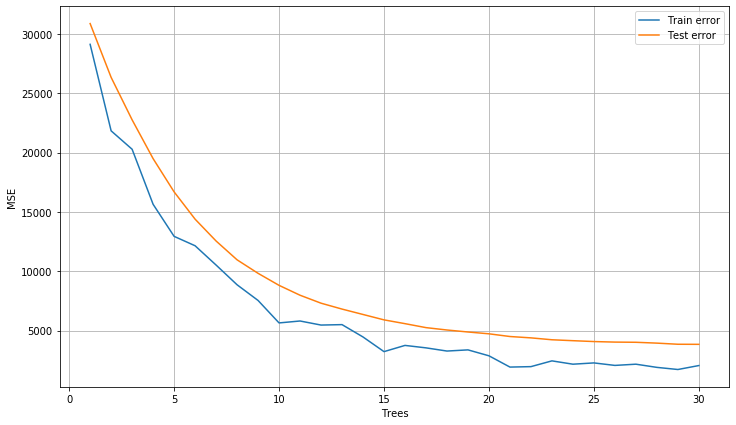

In [136]:
x = list(range(1, 31))
plt.figure(figsize = (12, 7))
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.plot(x, train_errors, label='Train error')
plt.plot(x, test_errors, label='Test error')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [137]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1908.8795
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке:	 3806.5664


In [126]:
%%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

Wall time: 12.6 s


In [127]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1733.9207
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке:	 4077.7932


__ВЫВОД:__   
Стохастический градиентный бустинг работает быстрее, чем обычный градиентный бустинг, при сопоставимом уровне качества.